In [7]:
from scipy.integrate import solve_ivp

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [8]:
# # Species:
# ATP = 2
# ADP = 0.
# Pi = 0.              # mM
# NADPH = 2        # mM
# NADPplus = 0.     # mM
# Lys = 0.             # mMs

# # ___________ [2, 1., 2, 1., 0.1, 0.] ___________ #
# Aspi = 2.   # No mover
# AspPi = 0.00001  # No MOVER
# ASAi = 0.00001   # NO MOVER Nivel Máximo de Thr
# HSi = 0.
# HSPi = 0.
# Thri = 0.


# Constants:
# VAKI = 0.088                # Flag 0.068
# VAKIII = 0.0094             # Flag 0.0054             
# VASD = 2                    # Flag 2
# VHDH = 10                   # Flag 10
# VHK = 45                   # Flag 100
# VTS = 10
# VATP = 0.012
# VATPII = 500

# VAKI = 0.068
# VAKIII = 0.00088
# VASD = 2
# VHDH = 10
# VHK = 100
# VTS = 10

Dado que:
$$
\begin{align*} 
\frac{d}{dt} ATP &= -V_{AK}\cdot ATP \cdot ASP \\
\frac{d}{dt} ATP &= -V_{HK} \cdot ATP \cdot HS \\
\end{align*}
$$
Entonces:

$$
\begin{align*}
\frac{d}{dt} ATP &= -V_{AK} \cdot ATP \cdot ASP -V_{HK} \cdot ATP \cdot HS \\
\frac{d}{dt} ATP &= -ATP \cdot (V_{ATP} \cdot ASP + V_{HK} \cdot HS) \\
\frac{d}{dt} ATP &= -ATP \cdot \nu_{ATP} \\
\end{align*}
$$

$$
\begin{align*}
\frac{d}{dt} Asp &= -\nu_{AKI} - \nu_{AKIII} \\
\frac{d}{dt} AspP &= \nu_{AKI} + \nu_{AKIII} - \nu_{vASD} \\
\frac{d}{dt} ASA &= \nu_{ASD} - \nu_{HDH} \\
\frac{d}{dt} HS &= \nu_{HDH} - \nu_{HK} \\
\frac{d}{dt} HSP &= \nu_{HK} - \nu_{TS} \\
\frac{d}{dt} Thr &= \nu_{TS} \\
\frac{d}{dt} ATP &= -ATP \cdot \nu_{ATP} \\
\end{align*}
$$

<!-- $$
\begin{align*} -->
# <img src="images/System.png" width=900 height=380 />
<!-- % \end{align*}
% $$ -->

In [9]:
# Species:
ADP = 0.
Pi = 0.             # mM
NADPH = 2           # mM
NADPplus = 0.       # mM
Lys = 0.            # mMs
# ___________  ___________ #
Aspi = 2.           # No mover
AspPi = 0.00001     # No MOVER
ASAi = 0.00001      # NO MOVER Nivel Máximo de Thr
HSi = 0.
HSPi = 0.
Thri = 0.
ATPi = 2.


# Constants:
VAKI = 0.088                # Flag 0.068
VAKIII = 0.0094             # Flag 0.0054             
VASD = 2                    # Flag 2
VHDH = 10                   # Flag 10
VHK = 45                   # Flag 100
VTS = 10
VATP = 0.012
VATPII = 500


# Parameters:
# - nuAKI:
KeqAK = 6.4 * pow(10, -4)
KAspAKI = 0.97              # +- 0.48 mM
KATPAKI = 0.98              # +- 0.5 mM
KAspPAKI = 0.017            # +- 0.004 mM
KADPAKI = 0.25              # mM
KiThrAKI = 0.167            # +- 0.003 mM
h1 = 4.09                   # +- 0.26
alphaAKI = 2.47             # +- 0.17


# - nuAKIII:
KeqAK = 6.4 * pow(10, -4)
KAspAKII = 0.32             # +- 0.08 mM
KATPAKIII = 0.22            # +- 0.22 mM
KAspPAKIII = 0.017          # +- 0.004 mM
KADPAKIII = 0.25            # mM
K1Lys = 0.391               # +- 0.08 mM
hlys = 2.8                  # +- 1.4


# nuASD
KeqASD = 2.84 * pow(10, 5)
KAspPASD = 0.022            # +- 0.001 mM
KNADPHASD = 0.029           # +- 0.002 mM
KASAASD = 0.11              # +- 0.008 mM
KNADPplusASD = 0.144        # +- 0.02 mM 
KPi = 10.2                  # +- 1.4 mM


# nuHDH
KeqHDH = 1 * pow(10, 11)    # M^-1
KASAHDH = 0.24              # +- 0.03 mM
KNADPHHDH = 0.037           # +- 0.006 mM
KHSHDH = 3.39               # +- 0.33 mM
KNADPplusHDH = 0.067        # +- 0.006 mM
KNADPplusAKIII = 0.067      # +- 0.006 mM == KNADPplusHDH
KiThr2 = 0.097              # mM
h2 = 1.41
alpha2 = 3.93 


# nuHK
KHSHK = 0.11   # mM
KATPHK = 0.072 # mM
KiThrHK = 1.09 # mM
KiLysHK = 9.45 # mM
KiHSHK  = 4.7  # mM
KiATPHK = 4.35 # mM

# nuTS
KHSPTS = 0.31   # +- 0.03 mM

In [10]:
def find_optimal_concentration(range_concentration=3, factor=1, constant=None, tmax=100.):
    solved_systems = []
    for i in tqdm(range(range_concentration)):
        i *= factor
        ADP = 0.
        Pi = 0.             # mM
        NADPH = 2.           # mM
        NADPplus = 0.       # mM
        Lys = 0.            # mMs
        # ___________  ___________ #
        AspPi = 0.00001     
        ASAi = 0.00001      
        HSi = 0.
        HSPi = 0.
        Thri = 0.

        if constant == False:
            Aspi = 2. + i
            ATPi = 2. + i

        elif constant == 'ATP':
            Aspi = 2. + i
            ATPi = 2.
        
        elif constant == 'Asp':
            Aspi = 2.
            ATPi = 2. + i

        elif constant == True:
            Aspi = 2.
            ATPi = 2.

        solved = solve_ivp(system, [0., tmax], [Aspi, AspPi,ASAi, HSi, HSPi, Thri, ATPi])
        solved_systems.append(solved)
    return solved_systems


def system(t, r):
    Asp, AspP, ASA, HS, HSP, Thr, ATP= r
    νAKI = VAKI*(Asp*ATP - (AspP*ADP/KeqAK)) / (KAspAKI*(1 + pow((Thr/KiThrAKI), h1) / 1 + pow((Thr/alphaAKI*KiThrAKI), h1)) + AspP*((KAspAKI/KAspPAKI)) + Asp)*(KATPAKI*(1 + (ADP/KADPAKI)) + ATP)
    νAKIII = (VAKIII * (Asp * ATP - (AspP * ADP/KeqAK))) / (1 + pow((Lys/K1Lys), hlys) * (KAspAKII*(1 + (AspP/KAspPAKIII)) + Asp)  * (KATPAKIII*(1 + (ADP/KADPAKIII)) + ATP))
    νASD = VASD * (AspP * NADPH - (ASA*NADPplus * Pi / KeqASD)) / (KAspPASD * (1 + (ASA / KASAASD)) * ( 1 + (Pi / KPi)) + AspP) * (KNADPHHDH * (1 + (NADPplus/ KNADPplusASD)) + NADPH)
    νHDH = VHDH * (ASA * NADPH - (HS * NADPplus/KeqHDH)) / (1 + pow((Thr/KiThr2), h2) / 1 + pow((Thr/alpha2*KiThr2), h2)) * KASAHDH*(1 + (HS/KHSHDH) + ASA) * (KNADPHHDH * (1 + (NADPplus/KNADPplusAKIII)) + NADPH)
    νHK = VHK * HS * ATP / (KHSHK*(ATP/KiATPHK)) * (1 + (Thr/KiThrHK) + HS) * (KATPHK * (1 + (HS / KiHSHK) + ATP)) * (1 + (Lys/KiLysHK))
    νTS = VTS*HSP/KHSPTS + HSP
    νATP = VATP * Asp + VATPII*HS

    dAsp    = -νAKI - νAKIII
    dAspP   =  νAKI + νAKIII - νASD
    dASA    =  νASD - νHDH
    dHS     =  νHDH - νHK
    dHSP    =  νHK  - νTS
    dThr    =  νTS
    dATP    =  - ATP * νATP

    return np.array([dAsp, dAspP, dASA, dHS, dHSP, dThr, dATP])

solved = solve_ivp(system, [0., 100.], [Aspi, AspPi,ASAi, HSi, HSPi, Thri, ATPi])


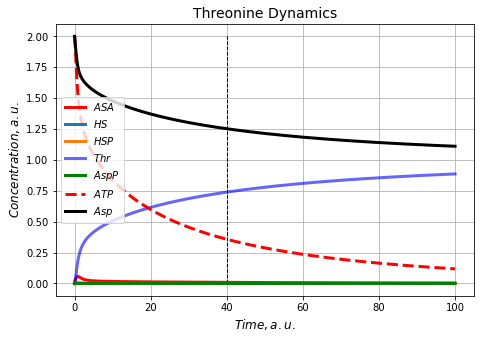

In [11]:
# figure = plt.figure(figsize=plt.figaspect(0.5))
figure = plt.figure(figsize=(7.5,5))
lw_ = 3

plt.plot(solved.t, solved.y[2], label=r'${ASA}$', color='red', lw=lw_)
plt.plot(solved.t, solved.y[3], label=r'${HS}$', lw=lw_)
plt.plot(solved.t, solved.y[4], label=r'${HSP}$', lw=lw_)
plt.plot(solved.t, solved.y[5], label=r'${Thr}$', color='blue', alpha=0.6, lw=lw_)
plt.plot(solved.t, solved.y[1], label=r'${AspP}$', color='green', lw=lw_)
plt.plot(solved.t, solved.y[6], '--',label=r'${ATP}$',color='red', lw=lw_)
plt.plot(solved.t, solved.y[0], label=r'${Asp}$', color='black', lw=lw_)

plt.legend(loc=6)
plt.grid(True)
plt.xlabel(r'${Time, a.u.}$', fontsize=12)
plt.ylabel(r'${Concentration, a.u.}$', fontsize=12)
plt.title('Threonine Dynamics', fontsize=14);
plt.vlines(40, 0, 2, colors='k', linestyles='dashed', lw=1)

# <img src="images/Concentration.png" width=500 height=320 />

In [12]:
factor = 10
solved_systems = find_optimal_concentration(range_concentration=12, factor=factor, constant=False, tmax=100.);

  8%|▊         | 1/12 [00:02<00:22,  2.04s/it]/tmp/ipykernel_962/3531893049.py:40: RuntimeWarning: invalid value encountered in double_scalars
  νAKI = VAKI*(Asp*ATP - (AspP*ADP/KeqAK)) / (KAspAKI*(1 + pow((Thr/KiThrAKI), h1) / 1 + pow((Thr/alphaAKI*KiThrAKI), h1)) + AspP*((KAspAKI/KAspPAKI)) + Asp)*(KATPAKI*(1 + (ADP/KADPAKI)) + ATP)
/tmp/ipykernel_962/3531893049.py:43: RuntimeWarning: invalid value encountered in double_scalars
  νHDH = VHDH * (ASA * NADPH - (HS * NADPplus/KeqHDH)) / (1 + pow((Thr/KiThr2), h2) / 1 + pow((Thr/alpha2*KiThr2), h2)) * KASAHDH*(1 + (HS/KHSHDH) + ASA) * (KNADPHHDH * (1 + (NADPplus/KNADPplusAKIII)) + NADPH)
100%|██████████| 12/12 [07:17<00:00, 36.47s/it]


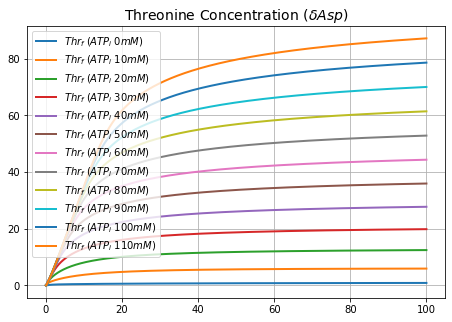

In [13]:
figure = plt.figure(figsize=(7.5,5))
[plt.plot(solved_systems[i].t, solved_systems[i].y[5], label=f'$Thr_f\;(ATP_i \; {i * factor} mM$)', lw=2) for i in range(len(solved_systems))]
plt.legend(loc=2)
plt.title(r'Threonine Concentration ($\delta{Asp})$', fontsize=14);
plt.grid(True)

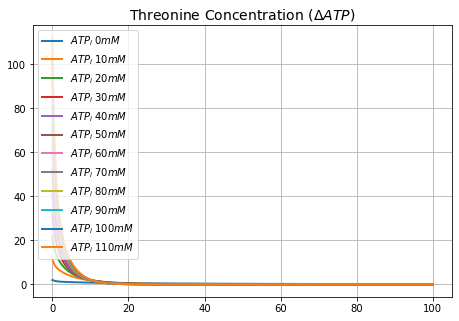

In [14]:
figure = plt.figure(figsize=(7.5,5))
[plt.plot(solved_systems[i].t, solved_systems[i].y[6], label=f'$ATP_i \;{i*factor} mM$', lw=2) for i in range(len(solved_systems))]
plt.legend(loc=2)
plt.title(r'Threonine Concentration ($\Delta{ATP})$', fontsize=14);
plt.grid(True)

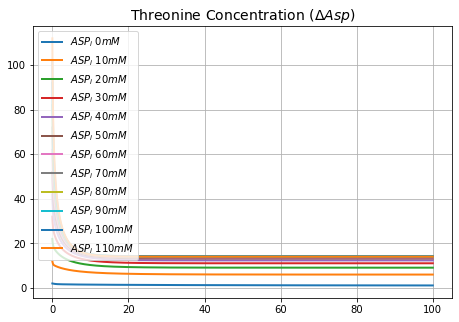

In [15]:
figure = plt.figure(figsize=(7.5,5))
[plt.plot(solved_systems[i].t, solved_systems[i].y[0], label=f'$ASP_i \;{i*factor} mM$', lw=2) for i in range(len(solved_systems))]
plt.legend(loc=2)
plt.title(r'Threonine Concentration ($\Delta{Asp})$', fontsize=14);
plt.grid(True)

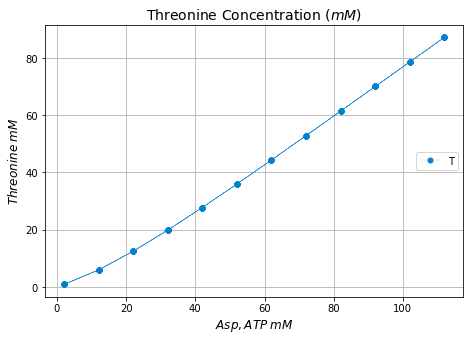

In [19]:
figure = plt.figure(figsize=(7.5,5))
x = [solved_systems[i].y[0][0] for i in range(len(solved_systems))];
y = [solved_systems[i].y[5][-1] for i in range(len(solved_systems))];
[plt.plot(x, y, '--', color='#0082D1',marker='o', lw=0.2, ms=5)  for i in range(len(solved_systems))];
plt.title(r'Threonine Concentration ($mM$)', fontsize=14);
plt.xlabel(r'${Asp, ATP}\;mM$', fontsize=12);
plt.ylabel(r'$Threonine\;mM$', fontsize=12);
plt.legend('T',loc=5);
plt.grid(True)
# plt.yscale('log')
# plt.xscale('log')

In [17]:
constants = ('Asp', 'ATP', False, True)
# multiple_solved_systems = [find_optimal_concentration(range_concentration=3, factor=1, constant=constant) for constant in constants]

In [18]:
# System_cAsp ,System_cATP, System_delta, System_constant = multiple_solved_systems

# x = [System_delta[i].y[0][0] for i in range(len(System_cAsp))];
# y = [System_delta[i].y[0][-1] for i in range(len(System_cAsp))];
# [plt.plot(x, y, color='blue', marker='o', lw=0, ms=5, alpha=0.3)  for i in range(len(System_cAsp))];